# Stim and LFP phase
## How well is the system detecting target LFP phases?

### Needs emk_neuro_analysis environment
### load LFP, DIO and time data

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import itertools
from scipy.signal import sosfiltfilt, butter, hilbert
from scipy.stats import circstd

from emk_analysis import builder_experiment as bld_exp
from emk_neuro_analysis.lfp import iterator as lfp_iter
from emk_neuro_analysis.position import iterator as pos_iter
from mountainlab_pytools import mdaio
from emk_analysis import iterator as emk_iter

from scipy import signal
from pathlib import Path
from rec_to_binaries.read_binaries import readTrodesExtractedDataFile

### Experiment parameters

In [3]:
# name of experiment
experiment_name = 'O3'

experiment_phase = 'stim'

# data drive
data_disk = 'nvme0'

# directory with the preprocessed/extracted data files
dir_preprocess = f'/media/{data_disk}/Data/{experiment_name}/preprocessing/'

# Figure folder, where you want to save the output figures. Usually in your experiment folder for analysis.
dir_fig = f'/media/{data_disk}/Analysis/{experiment_name}/Results/'

# Location of track config file. 
# This is an excel spreadsheet that specifies the identities of the DIO for your experiment.
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/CLC_linear_Config.xlsx')

# Location of day records. 
# This is an excel spreadsheet that lists details for each session on your experiment day.
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')

# chose the date - as a list
choose_dates = [ '20220505',]

# choose the epoch - as a list
epoch_list = [1,]

# choose the tetrodes - as a list
tet_list = [28, 27, 20, 19, 17, 16, 15, ]

### Build day records from track confi file and experiment file

In [4]:
data_days = []
for curr_date in choose_dates:

    fname_day_record = f'{dir_records}{curr_date}_{experiment_phase}_training_record.xlsx'
    
    dict_sessions_day = bld_exp.build_day_from_file(experiment_name, 
                                track_config_file=fname_config_track,
                                day_record_file=fname_day_record)
    data_days.append(dict_sessions_day)

dict_sessions_all = bld_exp.build_all_sessions(data_days)
pprint(dict_sessions_all)

{'20220505_01': {'date': '20220505',
                 'description': 'Closed-loop testing',
                 'end': Timestamp('2022-05-05 23:55:00'),
                 'experiment': 'O3',
                 'id': 1,
                 'name': 'stim',
                 'start': Timestamp('2022-05-05 01:00:00'),
                 'tasks': {'Track 1': {'animal_id': 'O3',
                                       'description': 'S',
                                       'dio': {'11': {'bit': '_',
                                                      'notes': None,
                                                      'type': 'Unnamed:'},
                                               'entrance_sensor': {'bit': 1,
                                                                   'notes': None,
                                                                   'type': 'in'},
                                               'exit_sensor': {'bit': 3,
                                                     

In [5]:
lfp_data, lfp_timestamp, _ = lfp_iter.iterate_lfp_load(dir_preprocess, 
                                                       tet_list,
                                                       choose_dates, 
                                                       epoch_list=epoch_list, 
                                                       remove_movement_artifact=False,
                                                       filter_linenoise=True,
                                                       print_debug=False)

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 28
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 27
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 20
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 17
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 16
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 15
filter 60Hz noise


<IPython.core.display.Javascript object>


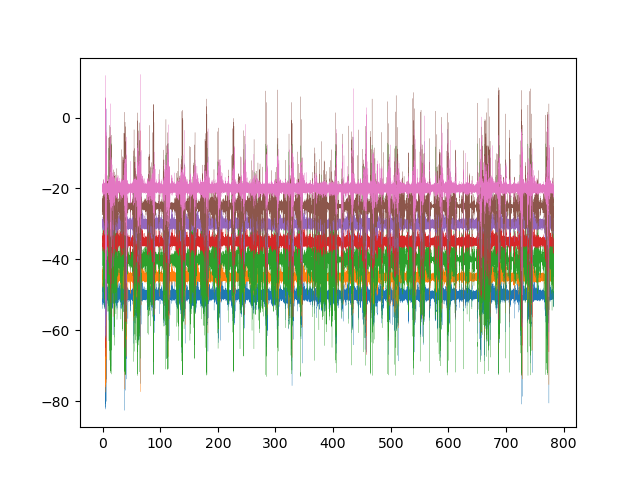

In [8]:
%matplotlib notebook

fs = 30000

for i, (k, v) in enumerate(lfp_data.items()):
    for e in epoch_list:
        plt.plot((np.array(lfp_timestamp.get(e))-np.array(lfp_timestamp.get(e))[0])/fs, 
                 np.array(v.get(e))/1000+5*(i-10), lw=.15)

In [9]:
def index_in(butter_filter, raw_data, num_std=0):
    filtered_data = sosfiltfilt(butter_filter,raw_data)
    filtered_envelope = np.abs(hilbert(filtered_data))
    bar = np.mean(filtered_envelope) + num_std*np.std(filtered_envelope)
    index_in = np.array(filtered_envelope) > bar
    return index_in


def true_phase(butter_filter, raw_data):
    filtered_data = sosfiltfilt(butter_filter,raw_data)
    filtered_phase = np.angle(hilbert(filtered_data)) + np.pi
    return filtered_phase


def generate_matrix(regr_buffer_size):
    sampling_axis = np.arange(regr_buffer_size)
    A = np.vstack([sampling_axis, np.ones(len(sampling_axis))]).T
    return A


def calculate_derv(A, buffer):
    curr_regr = buffer[:, np.newaxis]
    pinv = np.linalg.pinv(A)
    alpha = pinv.dot(curr_regr)
    return alpha[0][0]


def critical_point(derivative_history,time,regr_buffer_size,index_in,which,num_to_wait=5):
# def critical_point(derivative_history,time,regr_buffer_size,num_to_wait=5):
    critical_index = []
    critical_time = []
    current_sign = True
    sign_buffer = []

    for i in range(len(derivative_history)):
        if i == 0:
            current_sign = (derivative_history[0]>0)
            sign_buffer = [derivative_history[0]>0]*num_to_wait
            continue

        sign_buffer.append(derivative_history[i]>0)
        sign_buffer.pop(0)

        flip = True
        for sign in sign_buffer:
            if current_sign == sign:
                flip = False
                break
    
        if flip:
            current_sign = sign_buffer[-1]
            if which: 
            # which == True means you want the peaks
                if (not current_sign) and index_in[i+int(regr_buffer_size/2)-num_to_wait]:
                    # at peaks, current_sign already flipped to be false
                    critical_index.append(i+int(regr_buffer_size/2)-num_to_wait)
                    critical_time.append(time[i+int(regr_buffer_size/2)-num_to_wait])
            else:  
            # otherwise you want the troughs
                if current_sign and index_in[i+int(regr_buffer_size/2)-num_to_wait]: 
                    # at troughs, current_sign flipped to be true
                    critical_index.append(i+int(regr_buffer_size/2)-num_to_wait)
                    critical_time.append(time[i+int(regr_buffer_size/2)-num_to_wait])
    
    return np.array(critical_index), np.array(critical_time)


def select_target(butter_filter, raw_data, time, target, index_in, error_bound=0.0015, buffer_size=200):
    if target == 0 or target == np.pi:
        
        filtered_data = sosfiltfilt(butter_filter,raw_data)
        derivative_history = []
        A = generate_matrix(buffer_size)
        
        for i in range(buffer_size,len(filtered_data)):
            curr_buffer = filtered_data[i-buffer_size:i]
            curr_derv = calculate_derv(A,curr_buffer)
            derivative_history.append(curr_derv)
        
        target_index, target_time = critical_point(derivative_history,time,buffer_size,index_in,
                                                    target/np.pi,num_to_wait=3)
        
    else:
        
        target_index = []
        target_time = []
        filtered_phase = true_phase(butter_filter, raw_data)
        for i in range(len(filtered_phase)):
            if (0 <= (filtered_phase[i]-target) <= 0.0015) and index_in[i]: 
            # note that this parameter is very tricky, so the "ground truth" 
            # of target phase timestamps isn't absolute
                target_index.append(i)
                target_time.append(time[i])
            
    return target_index, target_time


def calculate_accuracy(target_time, hardware_on_time, window=0.060):
    hit = []
    detection_start = 0
    for i in range(len(target_time)):
        if target_time[i] <= hardware_on_time[0] <= target_time[i+1]:
            detection_start = i
            break
            
    for target in target_time[detection_start:]:
        for i in range(len(hardware_on_time)):
            if 0 <= (hardware_on_time[i]-target) <= window:
                hit.append(hardware_on_time[i])
                break
                
    return hit, len(hit)/len(target_time[detection_start:])


def calculate_precision(target_time, hardware_on_time, window=0.060):
    precise = []
    detection_start = 0
    for i in range(len(target_time)):
        if target_time[i] <= hardware_on_time[0] <= target_time[i+1]:
            detection_start = i
            break
                        
    for hardware in hardware_on_time:
        for target in target_time[detection_start:]:
            if 0 <= (hardware-target) <= 0.100:
                precise.append(hardware_on_time[i])
                break
               
    return precise, len(precise)/len(hardware_on_time)

In [12]:
target_lowcut = 4
target_highcut = 10
buffer_size = 200

tetrode = 28
target = 0

butter_filter = butter(1, [target_lowcut, target_highcut], 'bp', fs=fs/20, output='sos')
raw = lfp_data[tetrode][1]
# filtered = sosfiltfilt(butter_filter, raw)
time_data = (np.array(lfp_timestamp.get(e))-np.array(lfp_timestamp.get(e))[0])/fs

In [13]:
target_index, target_time = select_target(butter_filter, raw, (np.array(lfp_timestamp[1])-time_data[0])/fs,
                                          target, index_in(butter_filter, raw, num_std=0), error_bound=0.0015, 
                                          buffer_size=200)

In [ ]:
real = np.isin(np.array(lfp_timestamp[1])[target_index], 
               np.hstack([np.linspace(start, end, (end-start+1)) 
                          for start, end in zip(np.array(stim_timestamp)[stim_ends][::2], 
                                                np.array(stim_timestamp)[stim_ends][1::2])]))

In [ ]:
# visualize LFP, targets, and stims
%matplotlib notebook

time = (np.array(time_data) - time_data[0])/fs

raw = lfp_data[28][1]

# raw signal
plt.plot(time, raw/1000, c='lightgray', label='Raw')

# filtered signal
plt.plot(time, filtered/1000, lw=3, color='#00AEEF', label='6-10Hz')

# stimulation events
for on_time in stim_time:
    plt.plot([on_time, on_time], [-2, 2], c='r', lw=1.5)

# targets
plt.scatter(target_time[real], (filtered/1000)[target_index[real]], 
            c='k', s=25, zorder=3, label='target')

# plt.scatter(target_time, (filtered/1000)[target_index], 
#             c='k', s=25, zorder=3, label='target')

# legend placeholder
# plt.plot([0],[0], c='r', label='Stim')
# plt.legend()

plt.xlabel('Time (s)')
plt.ylabel('Signal (mV)')

### Accuracy and Precision

In [ ]:
hit, accuracy = calculate_accuracy(target_time[real], stim_time)
precise, precision = calculate_precision(target_time[real], stim_time)
print(accuracy)
print(precision)

### Lag

In [ ]:
# analyze general lag
%matplotlib notebook

on_lag_hist, on_lag_edges = np.histogram(np.hstack([stim - target_time[real] for stim in stim_time])*1000, 
                                         bins=20, range=(-100,100))

plt.plot(on_lag_edges[:-1],
         on_lag_hist/sum(on_lag_hist),)

plt.ylabel('Probability')
plt.xlabel('Lag (ms)')